In [1]:
from phoenix import sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 1000.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)

Phi_spheroid = plummer_potential
theta_spheroid = jnp.array([1e12, 10.0]) # (M, a) z.B. für Plummer

In [3]:
#Generate candidate actions
from phoenix.distributionfunctions_spheroidal import f_double_power_law
candidates, samples, soft_weights = sampling.sample_df_potential(f_double_power_law, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

Number of candidate actions: 250000


In [4]:
import jax
import jax.numpy as jnp

def compute_density_jax(x, y, z, weights, r_bins, z_bins):
    # 1. Compute radial distance r
    r = jnp.sqrt(x**2 + y**2)

    # 2. Use histogram2d to accumulate weights efficiently
    # This replaces the entire fori_loop and digitize logic
    counts, _, _ = jnp.histogram2d(
        r, z, 
        bins=[r_bins, z_bins], 
        weights=weights
    )

    # 3. Compute the volume of each bin
    # Use midpoint r for volume calculation to be more accurate
    r_mid = (r_bins[:-1] + r_bins[1:]) / 2
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    
    # Calculate volume of cylindrical shell: V = 2 * pi * r * dr * dz
    bin_volumes = 2 * jnp.pi * jnp.outer(r_mid * r_widths, z_widths)

    # 4. Normalize
    density = counts / bin_volumes
    valid_mask = (density > 0).astype(jnp.float32)
    
    return density, valid_mask

In [5]:
r_min = 0
r_max = 10
z_min = -5
z_max = 5
rbin = jnp.linspace(r_min, r_max, 20)
zbin = jnp.linspace(z_min, z_max, 20)

In [6]:
density, mask = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)

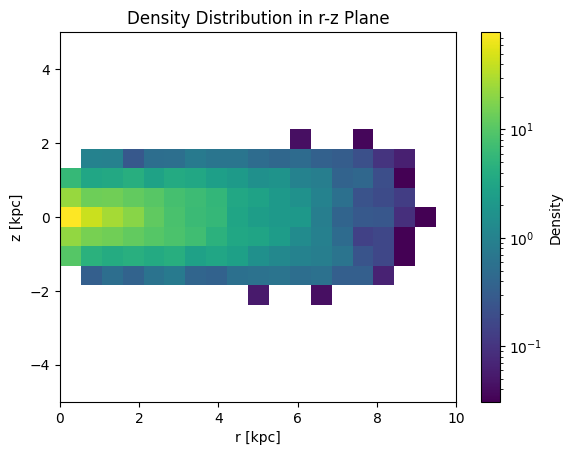

In [7]:
plt.imshow(density.T, origin='lower', aspect='auto',
           extent=[r_min, r_max, z_min, z_max], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Density Distribution in r-z Plane')
plt.savefig('./figures/spheroid_density.jpeg')
plt.show()

In [8]:
def compute_laplacian_on_grid(potential, theta, r_bins, z_bins):
    """
    Computes nabla^2 Phi (Laplacian) on the centers of the R-Z bins.
    """
    
    # 1. Define the Laplacian for a SINGLE point (x, y, z)
    def potential_wrapper(x, y, z):
        return potential(x, y, z, *theta)

    def laplacian_fn(x, y, z):
        # jax.hessian returns a 3x3 matrix of second derivatives
        # argnums=(0, 1, 2) makes it return a nested tuple structure relative to x,y,z
        # However, it's easier to treat input as a vector for Hessian logic,
        # but since our function takes scalars, we can just sum unmixed 2nd derivatives.
        
        # Method A: Direct curvature calculation (faster/simpler than full Hessian)
        # We use simple nested grad or specific derivative operators
        d2dx2 = jax.grad(lambda x_: jax.grad(potential_wrapper, argnums=0)(x_, y, z))(x)
        d2dy2 = jax.grad(lambda y_: jax.grad(potential_wrapper, argnums=1)(x, y_, z))(y)
        d2dz2 = jax.grad(lambda z_: jax.grad(potential_wrapper, argnums=2)(x, y, z_))(z)
        
        return d2dx2 + d2dy2 + d2dz2
    
    # 2. Vectorize the Laplacian function
    # Maps over inputs x, y, z
    laplacian_vmap = jax.vmap(laplacian_fn, in_axes=(0, 0, 0))

    # 3. Setup Grid (Bin Centers)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    
    # Create Meshgrid (indexing='ij' matches density shape)
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # 4. Convert R-Z to Cartesian X-Y-Z
    # We evaluate at y=0, so x=R
    X_flat = R_grid.flatten()
    Y_flat = jnp.zeros_like(X_flat)
    Z_flat = Z_grid.flatten()

    # 5. Compute
    laplacian_flat = laplacian_vmap(X_flat, Y_flat, Z_flat)
    
    # Reshape back to (N_r, N_z)
    laplacian_grid = laplacian_flat.reshape(R_grid.shape)
    
    return laplacian_grid

In [9]:

nabla2_Phi = compute_laplacian_on_grid(Phi_spheroid, theta_spheroid, rbin, zbin)

print("Laplacian shape:", nabla2_Phi.shape)

Laplacian shape: (19, 19)


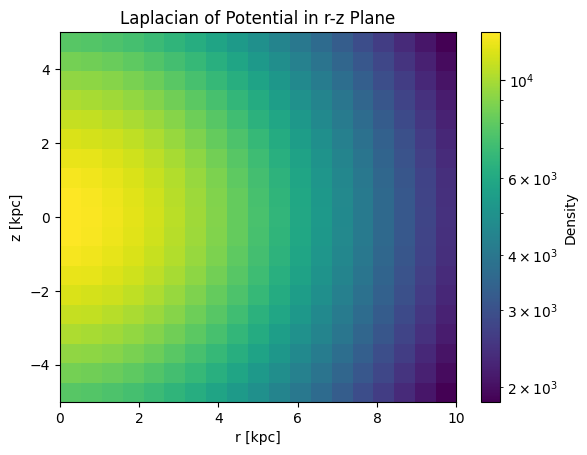

In [10]:
plt.imshow(nabla2_Phi.T, origin='lower', aspect='auto',
           extent=[r_min, r_max, z_min, z_max], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Laplacian of Potential in r-z Plane')
plt.savefig('./figures/spheroid_laplacian.jpeg')
plt.show()

In [11]:
from phoenix.constants import G

def compute_loss(key, params, Phi, theta, n_candidates, envelope_max, rbin, zbin):
    candidates, samples, soft_weights = sampling.sample_df_potential(f_double_power_law, key, params, Phi, theta, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]
    density, mask = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)
    nabla2_Phi = compute_laplacian_on_grid(Phi, theta, r_bins=rbin, z_bins=zbin)
    lossplane = (4*jnp.pi*G*density - nabla2_Phi)
    lossplane = lossplane * mask

    return lossplane

In [12]:
lossplane = compute_loss(key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, rbin, zbin)

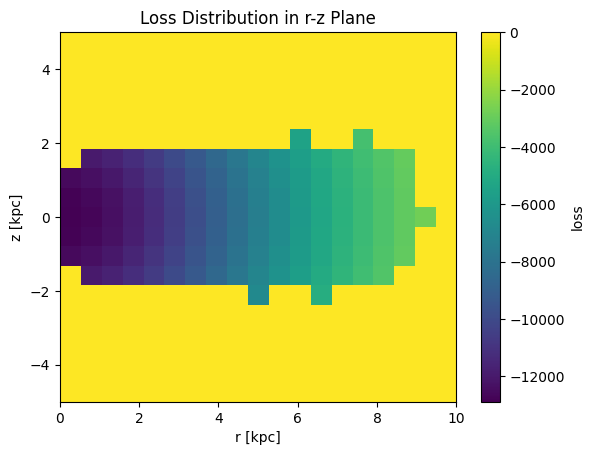

In [13]:
plt.imshow(lossplane.T, origin='lower', aspect='auto',
           extent=[r_min, r_max, z_min, z_max], cmap='viridis')#, norm=colors.LogNorm())
plt.colorbar(label='loss')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Loss Distribution in r-z Plane')
plt.show()

In [14]:
def compute_lossvalue(key, params, Phi, theta, n_candidates, envelope_max, rbin, zbin):
    candidates, samples, soft_weights = sampling.sample_df_potential(f_double_power_law, key, params, Phi, theta, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]
    density, mask = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)
    nabla2_Phi = compute_laplacian_on_grid(Phi, theta, r_bins=rbin, z_bins=zbin)
    lossplane = (4*jnp.pi*G*density - nabla2_Phi)
    lossplane = lossplane * mask
    loss = jnp.sum(lossplane**2)

    return loss

In [15]:
loss = compute_lossvalue(key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, rbin, zbin)

In [16]:
val_and_grad_fn = jax.value_and_grad(compute_lossvalue, argnums=3)
loss_val, theta_gradient = val_and_grad_fn(key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, rbin, zbin)

In [17]:
print(theta_gradient)

[ 1.729519e-02 -4.298330e+09]


In [18]:
import optax
#from tqdm import tqdm
import jax.numpy as jnp
import jax

def adam_optimizer(key, params, Phi_spheroid, theta_init, n_candidates, envelope_max, rbin, zbin, learning, num_iterations=2000):
    # 1. Start in Log Space
    current_log_theta = jnp.log(theta_init)
    
    # 2. Initialize the optimizer on the log values
    optimizer = optax.adam(learning)
    opt_state = optimizer.init(current_log_theta)

    # 3. Define the compiled update step
    @jax.jit
    def step(log_theta, state, step_key):
        # We define a helper to ensure JAX differentiates through the exp()
        def loss_wrapper(lt):
            t_phys = jnp.exp(lt)
            return compute_lossvalue(step_key, params, Phi_spheroid, t_phys, 
                                     n_candidates, envelope_max, rbin, zbin)
        
        # Now we differentiate w.r.t 'log_theta' directly
        loss_val, grads = jax.value_and_grad(loss_wrapper)(log_theta)
        
        updates, new_state = optimizer.update(grads, state, log_theta)
        new_log_theta = optax.apply_updates(log_theta, updates)
        
        return new_log_theta, new_state, loss_val

    loss_history = []
    theta_history = []
    
    # 4. The Training Loop
    #pbar = tqdm(range(num_iterations), desc="Optimizing Physics Parameters")

    for i in range(num_iterations):
        key, subkey = jax.random.split(key)
        
        current_log_theta, opt_state, loss_val = step(current_log_theta, opt_state, subkey)
        
        # Convert back to physical space for your records
        phys_theta = jnp.exp(current_log_theta)
        
        loss_history.append(float(loss_val))
        theta_history.append(phys_theta)
        
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss_val:.4f}, Theta: {phys_theta}")
            #pbar.set_postfix({"Loss": f"{loss_val:.2e}", "Theta": [f"{t:.2e}" for t in phys_theta]})

    return jnp.exp(current_log_theta), loss_history, theta_history

In [19]:
learning = 5e-2
theta_opt, loss_hist, theta_hist = adam_optimizer(key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, rbin, zbin, learning, num_iterations=3000)

Iteration 0, Loss: 8330837504.0000, Theta: [9.5123053e+11 1.0512709e+01]
Iteration 100, Loss: 24038360.0000, Theta: [4.0904812e+11 2.4823328e+01]
Iteration 200, Loss: 12412055.0000, Theta: [3.7388101e+11 2.7430676e+01]
Iteration 300, Loss: 7653841.5000, Theta: [3.5014712e+11 2.9525129e+01]
Iteration 400, Loss: 4957760.0000, Theta: [3.3295617e+11 3.1253101e+01]
Iteration 500, Loss: 3471157.7500, Theta: [3.1970102e+11 3.2729240e+01]
Iteration 600, Loss: 2742568.7500, Theta: [3.0901908e+11 3.4022411e+01]
Iteration 700, Loss: 2143130.0000, Theta: [3.0013145e+11 3.5178055e+01]
Iteration 800, Loss: 1720204.3750, Theta: [2.9252036e+11 3.6230270e+01]
Iteration 900, Loss: 1431017.1250, Theta: [2.8588969e+11 3.7198826e+01]
Iteration 1000, Loss: 1205846.1250, Theta: [2.8001167e+11 3.8099796e+01]
Iteration 1100, Loss: 1014931.5625, Theta: [2.7475658e+11 3.8942631e+01]
Iteration 1200, Loss: 870638.2500, Theta: [2.7000976e+11 3.9735416e+01]
Iteration 1300, Loss: 765852.0000, Theta: [2.6565334e+11 4.

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results(loss_history, theta_history):
    # Convert lists to numpy arrays
    loss_history = np.array(loss_history)
    theta_history = np.array(theta_history)  # Shape: (iterations, 2)

    # Create 3 subplots side-by-side
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Loss History (Log Scale)
    ax[0].plot(loss_history, color='black', lw=1.5)
    ax[0].set_yscale('log')
    ax[0].set_title("Total Loss Convergence", fontsize=14)
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Loss")
    ax[0].grid(True, which="both", ls="-", alpha=0.15)

    # 2. Theta 1 Evolution
    ax[1].plot(theta_history[:, 0], color='tab:blue', lw=2)
    ax[1].set_title(r"Parameter $\theta_1$: Mass", fontsize=14)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Value")
    ax[1].grid(True, alpha=0.2)

    # 3. Theta 2 Evolution
    ax[2].plot(theta_history[:, 1], color='tab:orange', lw=2)
    ax[2].set_title(r"Parameter $\theta_2: a$", fontsize=14)
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("Value")
    ax[2].grid(True, alpha=0.2)

    plt.tight_layout()
    plt.savefig('./figures/spheroid_loss_parameter_history.jpeg')
    plt.show()

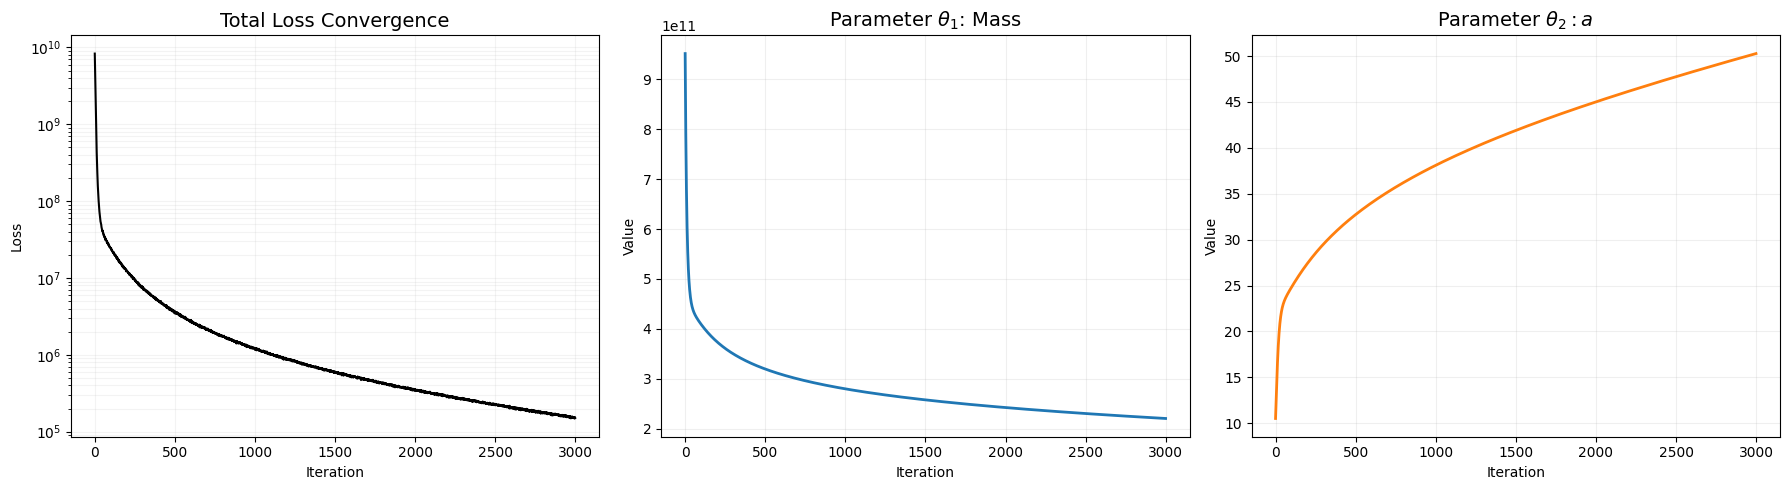

In [21]:
plot_training_results(loss_hist, theta_hist)

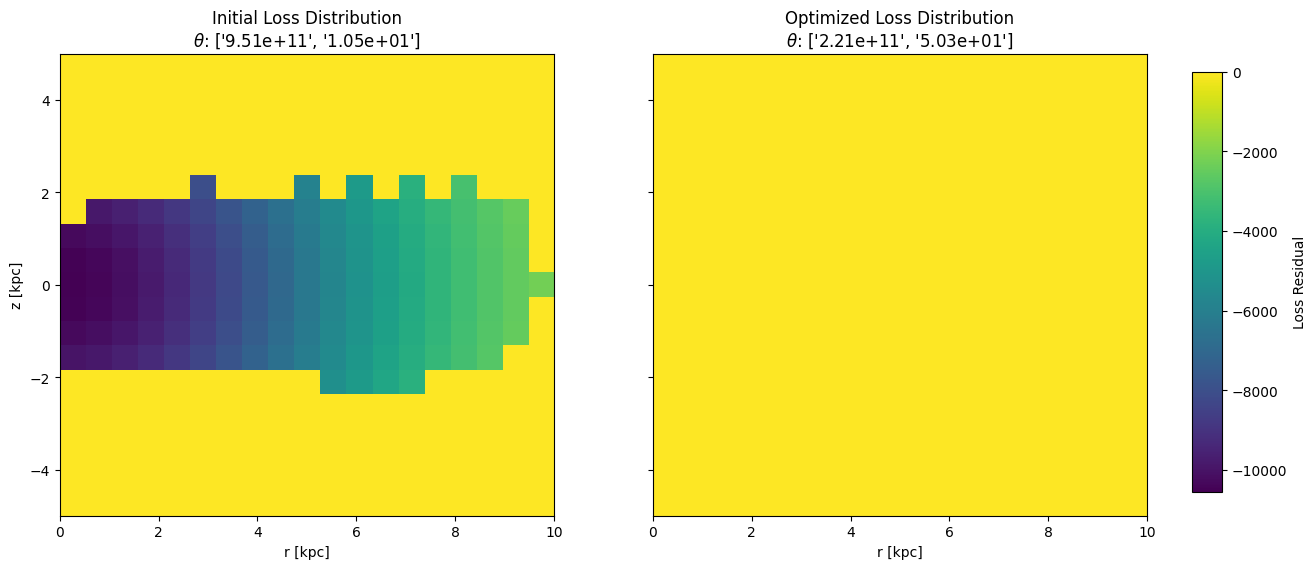

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

initial_lp = compute_loss(key, params, Phi_spheroid, theta_hist[0], n_candidates, envelope_max, rbin, zbin)
final_lp = compute_loss(key, params, Phi_spheroid, theta_hist[-1], n_candidates, envelope_max, rbin, zbin)

vmin = min(np.nanmin(initial_lp), np.nanmin(final_lp))
vmax = max(np.nanmax(initial_lp), np.nanmax(final_lp))

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Common settings for imshow
im_kwargs = {
    'origin': 'lower',
    'aspect': 'auto',
    'extent': [r_min, r_max, z_min, z_max],
    'cmap': 'viridis',
    'vmin': vmin,
    'vmax': vmax
}

# Left Plot: Initial
im0 = axes[0].imshow(initial_lp.T, **im_kwargs)
axes[0].set_title(f'Initial Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[0]]}')
axes[0].set_xlabel('r [kpc]')
axes[0].set_ylabel('z [kpc]')

# Right Plot: Optimized
im1 = axes[1].imshow(final_lp.T, **im_kwargs)
axes[1].set_title(f'Optimized Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[-1]]}')
axes[1].set_xlabel('r [kpc]')

# Add one shared colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Loss Residual')

plt.savefig('./figures/spheroid_loss_plane.jpeg')
plt.show()

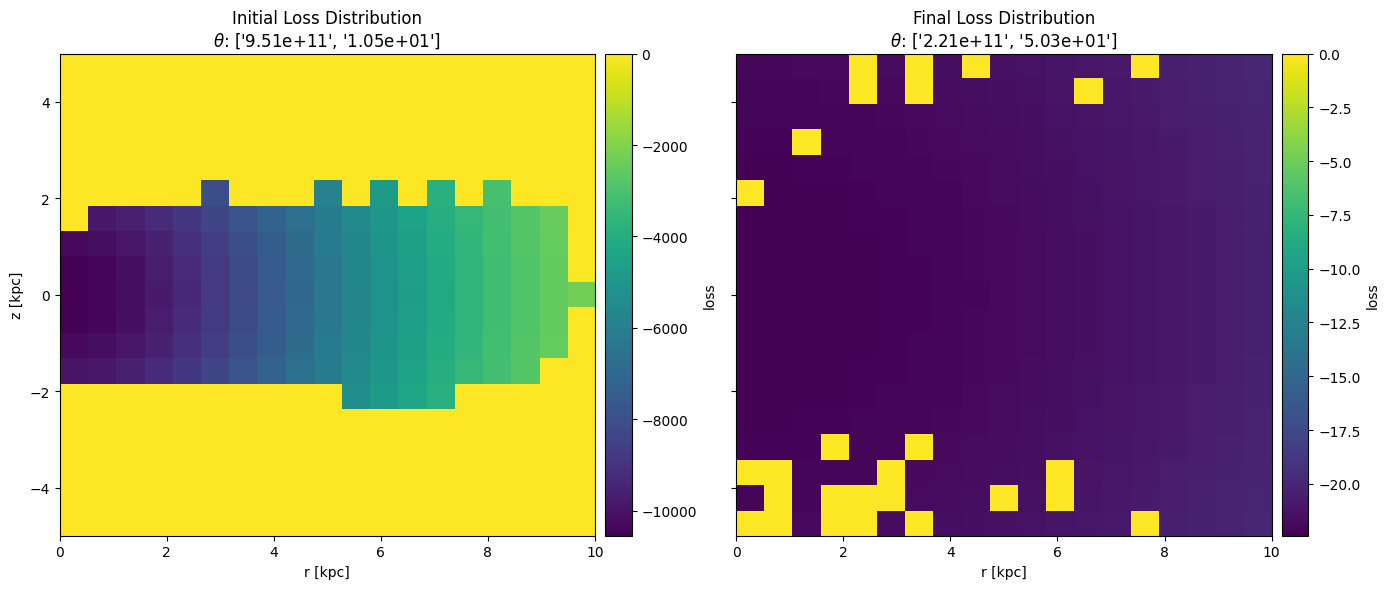

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define common imshow parameters
im_kwargs = {
    'origin': 'lower',
    'aspect': 'auto',
    'extent': [r_min, r_max, z_min, z_max],
    'cmap': 'viridis'
}

# --- Left Plot: Initial ---
im0 = axes[0].imshow(initial_lp.T, **im_kwargs)
axes[0].set_title(f'Initial Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[0]]}')
axes[0].set_xlabel('r [kpc]')
axes[0].set_ylabel('z [kpc]')

# Create individual colorbar for the left plot
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0, cax=cax0, label='loss')

# --- Right Plot: Final ---
im1 = axes[1].imshow(final_lp.T, **im_kwargs)
axes[1].set_title(f'Final Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[-1]]}')
axes[1].set_xlabel('r [kpc]')

# Create individual colorbar for the right plot
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cax1, label='loss')

plt.tight_layout()
plt.savefig('./figures/spheroid_loss_plane2.jpeg')
plt.show()

In [24]:
def get_density_and_mask(f_double_power_law, key, params, Phi, theta, n_candidates, envelope_max, rbin, zbin):

    candidates, samples, soft_weights = sampling.sample_df_potential(
        f_double_power_law, key, params, Phi, theta, n_candidates, envelope_max, tau=0.01
    )

    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(
        samples, params, key, Phi, theta
    )

    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]

    density, mask = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)
    
    return density, mask

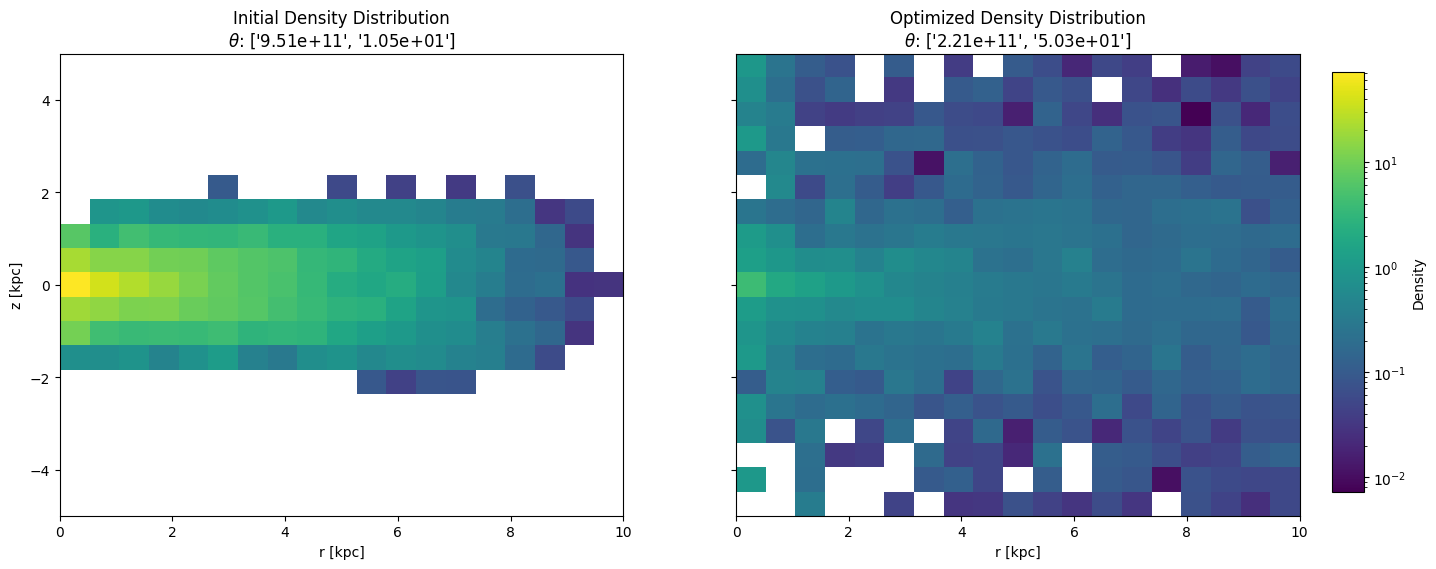

In [25]:
initial_density, mask_initial = get_density_and_mask(f_double_power_law, key, params, Phi_spheroid, theta_hist[0], n_candidates, envelope_max, rbin, zbin)
final_density, mask_final = get_density_and_mask(f_double_power_law, key, params, Phi_spheroid, theta_hist[-1], n_candidates, envelope_max, rbin, zbin)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
extent = [r_min, r_max, z_min, z_max]

combined_vals = np.concatenate([initial_density.flatten(), final_density.flatten()])
vmin = np.nanmin(combined_vals[combined_vals > 0])
vmax = np.nanmax(combined_vals)
shared_norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Initial Plot
im0 = axes[0].imshow(initial_density.T, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', norm=shared_norm)
axes[0].set_title(f'Initial Density Distribution\n$\\theta$: {[f"{t:.2e}" for t in theta_hist[0]]}')
axes[0].set_xlabel('r [kpc]')
axes[0].set_ylabel('z [kpc]')

# Optimized Plot
im1 = axes[1].imshow(final_density.T, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', norm=shared_norm)
axes[1].set_title(f'Optimized Density Distribution\n$\\theta$: {[f"{t:.2e}" for t in theta_hist[-1]]}')
axes[1].set_xlabel('r [kpc]')

fig.subplots_adjust(right=0.9) # Make room for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='Density')
plt.savefig('./figures/spheroid_density_optimization.jpeg')
plt.show()